## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [162]:
import numpy as np
import cv2
import glob
import os
import matplotlib.pyplot as plt
# %matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Image Size
shape_y = 720
shape_x = 1280

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Create folder to save calibration outputs
dir_output_cal = 'output_cal'
if not os.path.exists(dir_output_cal):
    os.mkdir(dir_output_cal)

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    cv2.resize(img, (shape_y, shape_x))
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imwrite(os.path.join(dir_output_cal,fname.split('/')[-1]),img)
        # cv2.waitKey(500)

# cv2.destroyAllWindows()

# Camera Calibration
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (shape_y, shape_x), None, None)

# Create folder to hold undistort images
dir_output_undist = 'output_undist'
if not os.path.exists(dir_output_undist):
    os.mkdir(dir_output_undist)
# Generate undistort images to verify
for fname in images:
    img = cv2.imread(fname)
    dst = cv2.undistort(img, mtx, dist, None, None)
    cv2.imwrite(os.path.join(dir_output_undist,fname.split('/')[-1]), dst)

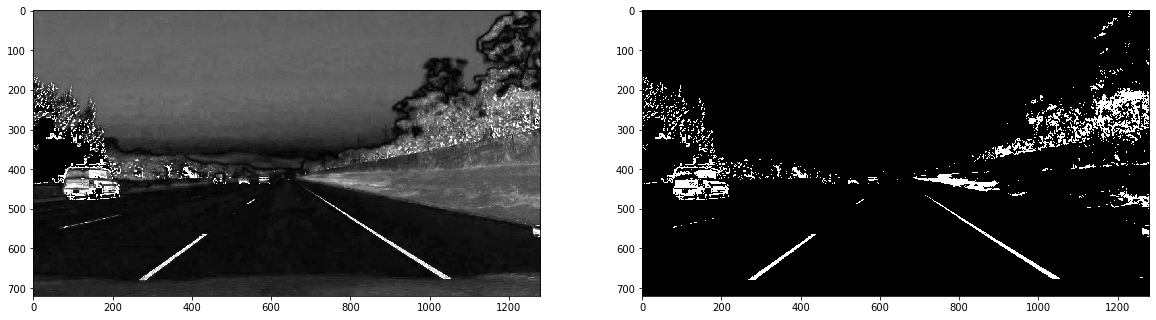

In [172]:
def hls_select(img, thresh=(0,255)):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s = hls[:,:,2]
    bin_img = np.zeros_like(s)
    bin_img[(thresh[0] < s) & (s <= thresh[1])] = 1
    return s, bin_img

img = cv2.imread('./test_images/straight_lines2.jpg')
dst = cv2.undistort(img, mtx, dist, None, None)

s, bin_img = hls_select(img, (120,255))
plt.subplots(1,2,figsize=(20,10))
plt.subplot(121)
plt.imshow(s, cmap='gray')
plt.subplot(122)
plt.imshow(bin_img, cmap="gray")


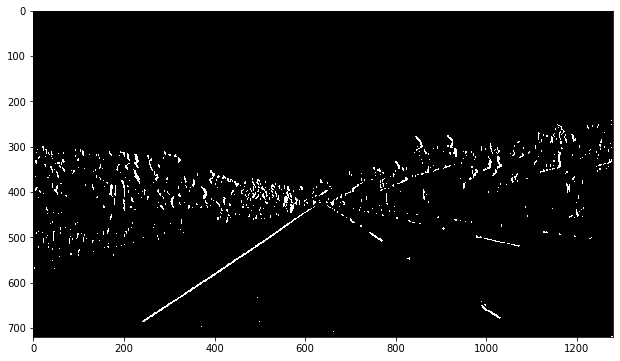

In [124]:
def sobel_1Dselect(img, axis='x', sobel_kernel=3, thresh=(0,255)):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if axis == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    sobel = sobel/np.max(sobel)*255
    bin_img = np.zeros_like(gray)
    bin_img[(sobel > thresh[0]) & (sobel <= thresh[1])] = 1
    return bin_img

bin_img = sobel_1Dselect(img,'x', 7, (30,255))
fig, ax = plt.subplots(figsize=(12, 6))
ax.imshow(bin_img, cmap="gray")

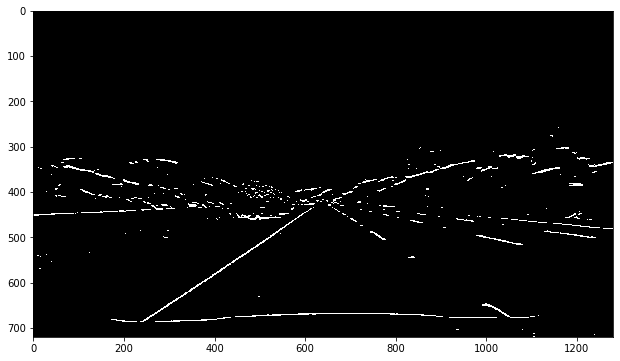

In [125]:
bin_img = sobel_1Dselect(img,'y', 7, (50,255))
fig, ax = plt.subplots(figsize=(12, 6))
ax.imshow(bin_img, cmap="gray")

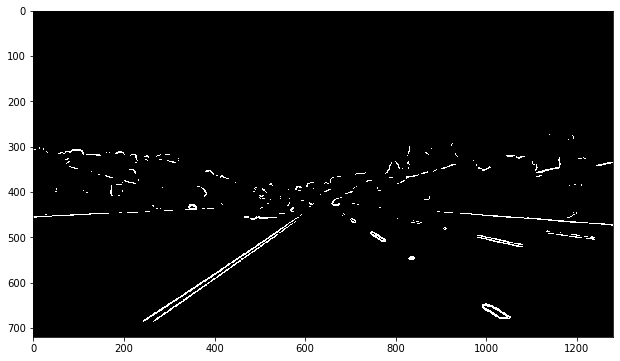

In [126]:
def sobel_mag_select(img, sobel_kernel=3, thresh=(0,255)):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.sqrt(sobelx**2+sobely**2)
    abs_sobel = (abs_sobel/np.max(abs_sobel)*255).astype(np.uint8)
    bin_img = np.zeros_like(gray)
    bin_img[(abs_sobel > thresh[0]) & (abs_sobel <= thresh[1])] = 1
    return bin_img

bin_img = sobel_mag_select(img, 15, (100,255))
fig, ax = plt.subplots(figsize=(12, 6))
ax.imshow(bin_img, cmap="gray")
    

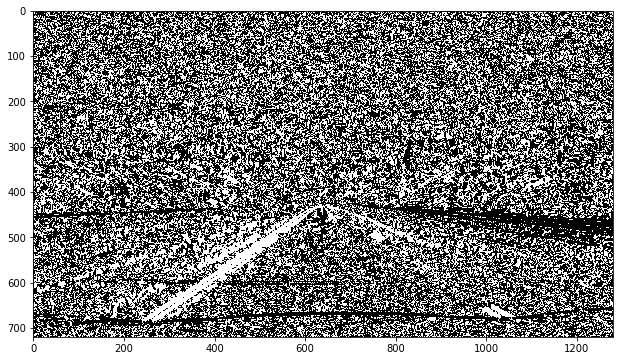

In [127]:
def sobel_dir_select(img, sobel_kernel=3, thresh=(0,np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    sobel_angle = np.arctan2(np.absolute(sobely),np.absolute(sobelx))
    bin_img = np.zeros_like(gray)
    bin_img[(sobel_angle > thresh[0]) & (sobel_angle <= thresh[1])] = 1
    return bin_img

bin_img = sobel_dir_select(img, 15, (0.7,1.3))
fig, ax = plt.subplots(figsize=(12, 6))
ax.imshow(bin_img, cmap="gray")

## And so on and so forth...

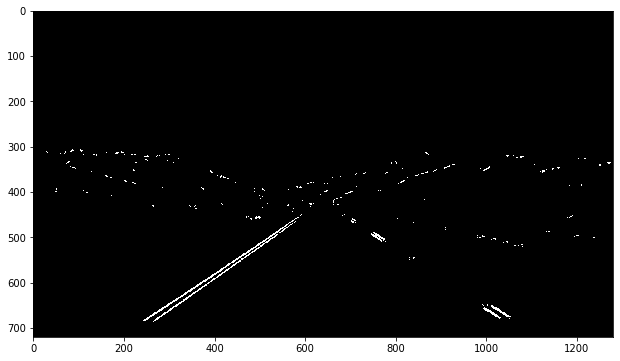

In [128]:
bin_dir = sobel_dir_select(img, 15, (0.7,1.3))
bin_mag = sobel_mag_select(img,15,(100,255))
bin_img = np.zeros_like(gray)
bin_img[(bin_dir == 1) & (bin_mag == 1)] = 1
fig, ax = plt.subplots(figsize=(12, 6))
ax.imshow(bin_img, cmap="gray")

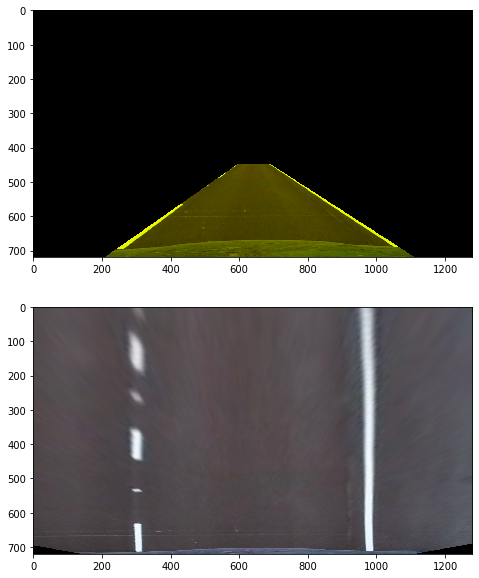

In [175]:


ysize=720
xsize=1280
margin = 300
img_undist = cv2.undistort(img, mtx, dist, None, None)
src = np.array([[(595,450),(690,450),(1108,719),(210, 719)]])
vertices = np.array([[(130, ysize-1),(480-40,330),(480+70,330),(xsize-1-30,ysize-1)]])
mask = np.zeros_like(img)
mask = cv2.fillPoly(mask, src, (255,255))
new_img = cv2.bitwise_and(img_undist, mask)
plt.subplots(2,1,figsize=(20, 10))
plt.subplot(211)
plt.imshow(new_img)
src = src.astype('float32')
dst = np.array([(margin,0),(1280-margin,0),(1280-margin,719),(margin,719)], dtype="float32")
M = cv2.getPerspectiveTransform(src, dst)
warped = cv2.warpPerspective(img_undist, M, (1280,720), flags=cv2.INTER_LINEAR)
plt.subplot(212)
plt.imshow(warped)
